In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

print(f"GPU available: {torch.cuda.is_available()}")

GPU available: True


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, ))])

In [6]:
train_set = torchvision.datasets.MNIST('mnist',
                                       train=True,
                                       download=True,
                                       transform=transform)

test_set = torchvision.datasets.MNIST('mnist',
                                      train=False,
                                      download=True,
                                      transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [7]:
print(f"Train set : {train_set.data.shape}")
print(f"Test set : {test_set.data.shape}")

Train set : torch.Size([60000, 28, 28])
Test set : torch.Size([10000, 28, 28])


In [8]:
import numpy as np
import matplotlib.pyplot as plt

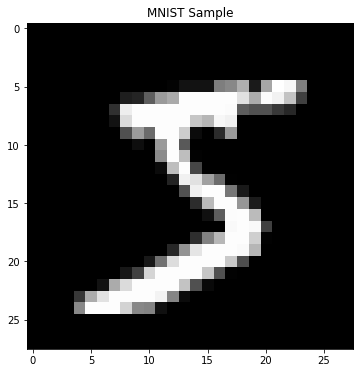

In [43]:
def imshow(title="", image=None, size=6):
    h, w = image.shape[0], image.shape[1]
    aspect_ratio = w / h
    plt.figure(figsize=(size * aspect_ratio, size))
    plt.imshow(image.cpu().numpy(), cmap='gray')
    plt.title(title)
    plt.show()


image = train_set.data[0]
imshow("MNIST Sample", image)

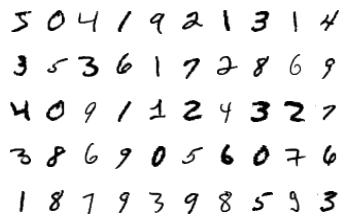

In [10]:
figure = plt.figure()
num_of_images = 50

for i in range(0, num_of_images):
    plt.subplot(5, 10, i + 1)
    plt.axis('off')
    plt.imshow(train_set.data[i], cmap='gray_r')

In [11]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=6)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=128,
                                          shuffle=False,
                                          num_workers=6)

In [12]:
data_iter = iter(train_loader)

images, labels = data_iter.next()

print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [13]:
labels[0]

tensor(1)

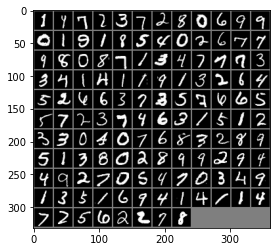

In [14]:
def imshow_v2(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()


imshow_v2(torchvision.utils.make_grid(images, nrow=12))

In [15]:
a = torch.randn((16, 3,5,5))

In [16]:
torch.flatten(a, start_dim=1).shape

torch.Size([16, 75])

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [19]:
net = Net().to(device)
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [21]:
from tqdm.autonotebook import tqdm

epochs = 10

epoch_log = []
loss_log = []
accuracy_log = []

for epoch in range(epochs):
    with tqdm(train_loader, desc=f"Train Epoch {epoch}", unit="batch") as train_epoch:
        batch_id = 0
        running_loss = 0.0

        for inputs, labels in train_epoch:
            net.train()
            batch_id += 1

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_id % 50 == 0:

                avg_train_loss_from_last_50_samples = running_loss / 50
                running_loss = 0.0

                correct_count = 0
                total = 0
                net.eval()

                with torch.no_grad():
                    for inputs, labels in test_loader:

                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        outputs = net(inputs)

                        predicted = torch.argmax(outputs, dim=1)
                        total += labels.shape[0]
                        correct_count += (predicted == labels).sum().item()

                    val_accuracy = 100.0 * correct_count / total
                    print(f"loss_avg={avg_train_loss_from_last_50_samples}, val_accuracy={val_accuracy}")
                    train_epoch.set_postfix(loss_avg=avg_train_loss_from_last_50_samples, val_accuracy=val_accuracy)

        epoch_log.append(epoch)
        loss_log.append(avg_train_loss_from_last_50_samples)
        accuracy_log.append(val_accuracy)

Train Epoch 0:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=2.2743527841567994, val_accuracy=50.66
loss_avg=2.1520144271850588, val_accuracy=74.36
loss_avg=1.8271428084373473, val_accuracy=79.26
loss_avg=1.154320046901703, val_accuracy=83.61
loss_avg=0.6525044226646424, val_accuracy=86.88
loss_avg=0.5051304495334625, val_accuracy=87.99
loss_avg=0.4137884539365768, val_accuracy=89.27
loss_avg=0.4002853861451149, val_accuracy=89.97
loss_avg=0.36205165326595307, val_accuracy=90.53


Train Epoch 1:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.3384536802768707, val_accuracy=90.94
loss_avg=0.32783146113157274, val_accuracy=91.61
loss_avg=0.32128532975912094, val_accuracy=91.62
loss_avg=0.28739325344562533, val_accuracy=92.0
loss_avg=0.29781522750854494, val_accuracy=92.19
loss_avg=0.2810025981068611, val_accuracy=92.7
loss_avg=0.2794251656532288, val_accuracy=92.69
loss_avg=0.26872906982898714, val_accuracy=92.92
loss_avg=0.2592581829428673, val_accuracy=93.38


Train Epoch 2:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.2414967228472233, val_accuracy=93.57
loss_avg=0.2488989405333996, val_accuracy=93.54
loss_avg=0.23641891092061995, val_accuracy=93.73
loss_avg=0.22385830119252204, val_accuracy=94.16
loss_avg=0.22481638222932815, val_accuracy=93.74
loss_avg=0.21171648770570756, val_accuracy=94.17
loss_avg=0.19636078119277955, val_accuracy=94.63
loss_avg=0.1938948990404606, val_accuracy=94.73
loss_avg=0.1977784365415573, val_accuracy=94.91


Train Epoch 3:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.1996008935570717, val_accuracy=94.98
loss_avg=0.1711990888416767, val_accuracy=95.18
loss_avg=0.16736992359161376, val_accuracy=95.45
loss_avg=0.17271887883543968, val_accuracy=95.57
loss_avg=0.15978387579321862, val_accuracy=95.6
loss_avg=0.17483195707201957, val_accuracy=95.66
loss_avg=0.15401115506887436, val_accuracy=95.73
loss_avg=0.15439598724246026, val_accuracy=96.02
loss_avg=0.14580019190907478, val_accuracy=96.09


Train Epoch 4:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.13577219806611537, val_accuracy=95.98
loss_avg=0.15016355663537978, val_accuracy=96.38
loss_avg=0.13625141069293023, val_accuracy=96.29
loss_avg=0.13472252130508422, val_accuracy=96.54
loss_avg=0.13124738402664662, val_accuracy=96.7
loss_avg=0.1302465832978487, val_accuracy=96.76
loss_avg=0.11979300580918789, val_accuracy=96.94
loss_avg=0.1130151765793562, val_accuracy=96.88
loss_avg=0.11884739816188812, val_accuracy=97.02


Train Epoch 5:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.11685933761298656, val_accuracy=96.94
loss_avg=0.12347137004137039, val_accuracy=97.08
loss_avg=0.10748391166329384, val_accuracy=97.02
loss_avg=0.10757089085876942, val_accuracy=97.03
loss_avg=0.10141561642289161, val_accuracy=97.2
loss_avg=0.10773340478539467, val_accuracy=97.33
loss_avg=0.09844796970486641, val_accuracy=97.24
loss_avg=0.09492119438946248, val_accuracy=97.33
loss_avg=0.10291250236332417, val_accuracy=97.45


Train Epoch 6:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.08749545749276877, val_accuracy=97.38
loss_avg=0.09842630192637443, val_accuracy=97.38
loss_avg=0.09108367390930652, val_accuracy=97.66
loss_avg=0.09633432120084763, val_accuracy=97.62
loss_avg=0.09210812881588935, val_accuracy=97.51
loss_avg=0.08802640374749898, val_accuracy=97.65
loss_avg=0.08860155899077654, val_accuracy=97.6
loss_avg=0.07610176242887974, val_accuracy=97.61
loss_avg=0.08970411259680987, val_accuracy=97.67


Train Epoch 7:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.07966805033385754, val_accuracy=97.72
loss_avg=0.08082032110542059, val_accuracy=97.66
loss_avg=0.08200741562992335, val_accuracy=97.86
loss_avg=0.076673650033772, val_accuracy=97.93
loss_avg=0.08740463461726904, val_accuracy=97.92
loss_avg=0.07774998508393764, val_accuracy=97.78
loss_avg=0.06965814657509327, val_accuracy=97.74
loss_avg=0.07631882093846798, val_accuracy=98.02
loss_avg=0.07026057042181492, val_accuracy=98.01


Train Epoch 8:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.07357541786506772, val_accuracy=97.92
loss_avg=0.07908281087875366, val_accuracy=97.94
loss_avg=0.07145348278805613, val_accuracy=98.05
loss_avg=0.07713537614792586, val_accuracy=97.99
loss_avg=0.06700243372470141, val_accuracy=98.0
loss_avg=0.0637232255935669, val_accuracy=98.08
loss_avg=0.06644267924129962, val_accuracy=98.09
loss_avg=0.0627828174829483, val_accuracy=98.15
loss_avg=0.06872482765465975, val_accuracy=98.11


Train Epoch 9:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.06052642149850726, val_accuracy=98.05
loss_avg=0.059780564699321984, val_accuracy=98.13
loss_avg=0.06319705110043287, val_accuracy=98.08
loss_avg=0.06382170472294092, val_accuracy=98.09
loss_avg=0.05972752247005701, val_accuracy=98.11
loss_avg=0.07306540381163358, val_accuracy=98.04
loss_avg=0.06527586426585913, val_accuracy=98.24
loss_avg=0.06841764189302921, val_accuracy=98.16
loss_avg=0.06035528603941202, val_accuracy=98.28


In [22]:
torch.save(net.state_dict(), 'model.pth')

In [23]:
trained_model = Net().to(device)
trained_model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

images shape : torch.Size([128, 1, 28, 28])
labels shape : torch.Size([128])
outputs shape : torch.Size([128, 10])
predictions shape : torch.Size([128])


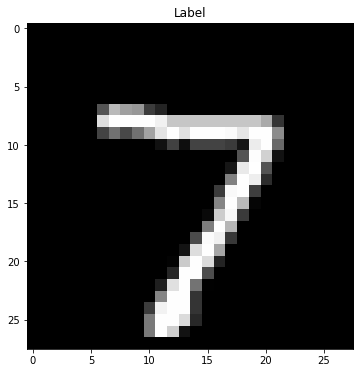

Label : 7
Predicted : 7


In [24]:
test_iter = iter(test_loader)

images, labels = test_iter.next()


print(f"images shape : {images.shape}")
print(f"labels shape : {labels.shape}")

images = images.to(device)
labels = labels.to(device)

outputs = trained_model(images)
print(f"outputs shape : {outputs.shape}")

_, predictions = torch.max(outputs, 1)
print(f"predictions shape : {predictions.shape}")

imshow(f"Label", images[0].cpu().squeeze())
print(f"Label : {labels[0].cpu()}")
print(f"Predicted : {predictions[0]}")

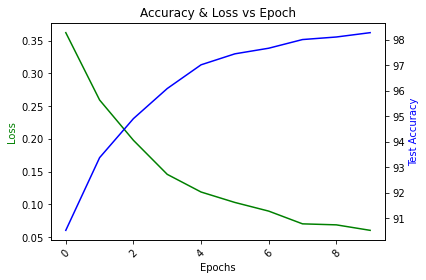

In [25]:
fig, ax1 = plt.subplots()

plt.title('Accuracy & Loss vs Epoch')
plt.xticks(rotation=45)

ax2 = ax1.twinx()

ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

In [27]:
correct = 0
total = 0

trained_model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = trained_model(inputs)

        predicted = torch.argmax(outputs, dim=1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy : {accuracy}")

Test Accuracy : 98.1


Actual label : 6, Predicted label : 0


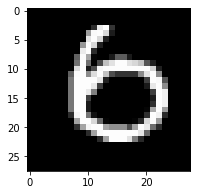

Actual label : 2, Predicted label : 7


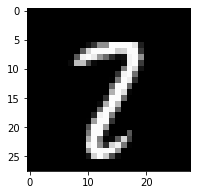

Actual label : 5, Predicted label : 3


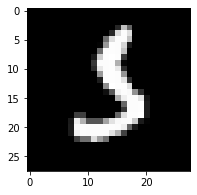

Actual label : 6, Predicted label : 0


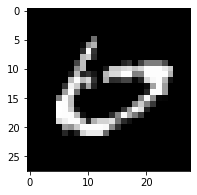

Actual label : 3, Predicted label : 5


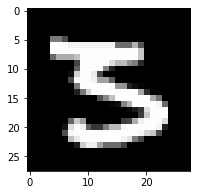

Actual label : 8, Predicted label : 2


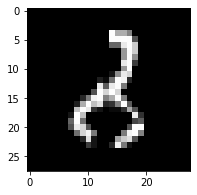

Actual label : 2, Predicted label : 8


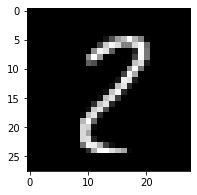

Actual label : 2, Predicted label : 1


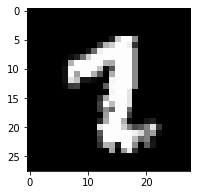

Actual label : 7, Predicted label : 3


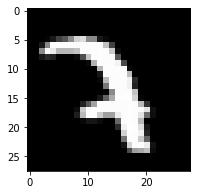

Actual label : 8, Predicted label : 4


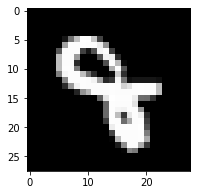

Actual label : 0, Predicted label : 5


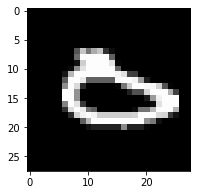

Actual label : 5, Predicted label : 8


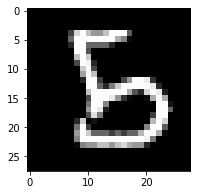

Actual label : 4, Predicted label : 9


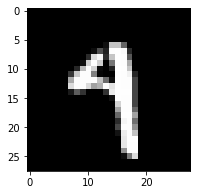

Actual label : 7, Predicted label : 9


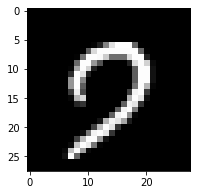

Actual label : 9, Predicted label : 7


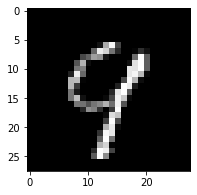

In [49]:
trained_model.eval()

misclassified_count = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = trained_model(inputs)

        labels_predictions = torch.argmax(outputs, dim=1)

        for i in range(inputs.shape[0]):
            label_prediction = labels_predictions[i].item()
            label = labels[i].item()
            if label != label_prediction and misclassified_count < 15:
                misclassified_count += 1
                print(f"Actual label : {label}, Predicted label : {label_prediction}")
                imshow("", inputs[i].squeeze(), size=3)

In [52]:
from sklearn.metrics import confusion_matrix

labels_predictions_accum = torch.zeros(0, dtype=torch.long, device='cpu')
labels_accum = torch.zeros(0, dtype=torch.long, device='cpu')

trained_model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = trained_model(inputs)

        labels_predictions = torch.argmax(outputs, dim=1)

        labels_predictions_accum = torch.cat([labels_predictions_accum, labels_predictions.view(-1).cpu()])
        labels_accum = torch.cat([labels_accum, labels.view(-1).cpu()])

confusion_matrix = confusion_matrix(y_true=labels_accum.numpy(), y_pred=labels_predictions_accum.numpy())
print("Confusion Matrix")
print(confusion_matrix)

Confusion Matrix
[[ 971    0    1    0    1    1    3    1    2    0]
 [   0 1126    2    1    0    1    4    0    1    0]
 [   2    7 1007    4    3    0    0    4    4    1]
 [   1    0    2  995    0    2    0    1    1    8]
 [   1    0    1    0  969    0    3    0    2    6]
 [   3    0    0    5    0  874    3    1    1    5]
 [   4    2    0    0    2    2  945    0    3    0]
 [   2    3   14    3    1    0    0  994    1   10]
 [   4    0    2    3    4    2    4    2  945    8]
 [   3    4    0    3    9    2    1    3    0  984]]


In [53]:
print("Per-class accuracy")

classes_accuracies = 100 * confusion_matrix.diagonal() / confusion_matrix.sum(axis=1)

for i, class_accuracy in enumerate(classes_accuracies):
    print(f"Class : {i} Accuracy : {class_accuracy}")

Per-class accuracy
Class : 0 Accuracy : 99.08163265306122
Class : 1 Accuracy : 99.20704845814979
Class : 2 Accuracy : 97.57751937984496
Class : 3 Accuracy : 98.51485148514851
Class : 4 Accuracy : 98.67617107942974
Class : 5 Accuracy : 97.98206278026906
Class : 6 Accuracy : 98.64300626304802
Class : 7 Accuracy : 96.69260700389106
Class : 8 Accuracy : 97.02258726899385
Class : 9 Accuracy : 97.52229930624381


In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_true=labels_accum.numpy(), y_pred=labels_predictions_accum.numpy()))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.99      0.97      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

